# Homework 5 - Task 3

Gabriel Gilling and Juan Lopez-Martin

In [0]:
import cv2
import numpy as np
import os
from keras.utils import np_utils
import os
import shutil
import numpy as np
from keras.models import Sequential, Model, Input
from keras.utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Average, BatchNormalization, Dropout, Flatten, Add, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras import applications
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
%matplotlib inline

Using TensorFlow backend.


In [0]:
%%capture
! wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
! unzip cell_images.zip

In [0]:
%%capture
! wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/malaria_cell_classification_code.zip
! unzip malaria_cell_classification_code.zip

In [0]:
class1_data_dir = 'cell_images/Parasitized'
class0_data_dir = 'cell_images/Uninfected'
train_samples = 10000 
valid_samples = 2000 #validation samples
num_classes = 2
img_rows_orig = 100
img_cols_orig = 100

def load_data(label_number):
    # Load training images
    if (label_number==1):
      class_data_dir = 'cell_images/Parasitized'
    else:
      class_data_dir = 'cell_images/Uninfected'

    class1_data = os.listdir(class_data_dir)
    total = len(class1_data)
    
    X_train = np.ndarray((total, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Loading images...')
    print('-'*30)
    toremove = []
    for idx, image_name in enumerate(class1_data):
        try:
          img = cv2.imread(os.path.join(class_data_dir, image_name), cv2.IMREAD_COLOR)
          img = cv2.resize(img, (100, 100))
          img = np.array([img])
          X_train[i] = img
        except Exception as e:
          print("Error for: ", image_name)
          toremove.append(idx)

        if i % 2500 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1 

    X_train = np.delete(X_train, toremove, axis=0)
    Y_train = np.zeros(len(X_train), dtype='uint8')+label_number
              
    print('Loading done.')
    
    print('Transform targets to keras compatible format.')
    Y_train = np_utils.to_categorical(Y_train, num_classes)

    np.save('imgs_class' + str(label_number) + '.npy', X_train, Y_train)
    return X_train, Y_train

In [0]:
X_one, Y_one = load_data(label_number = 1)
X_zero, Y_zero = load_data(label_number = 0)

------------------------------
Loading images...
------------------------------
Done: 0/13780 images
Done: 2500/13780 images
Done: 5000/13780 images
Error for:  Thumbs.db
Done: 7500/13780 images
Done: 10000/13780 images
Done: 12500/13780 images
Loading done.
Transform targets to keras compatible format.
------------------------------
Loading images...
------------------------------
Done: 0/13780 images
Done: 2500/13780 images
Done: 5000/13780 images
Error for:  Thumbs.db
Done: 7500/13780 images
Done: 10000/13780 images
Done: 12500/13780 images
Loading done.
Transform targets to keras compatible format.


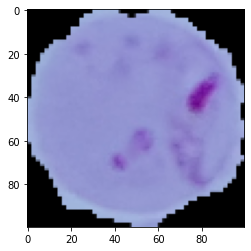

In [0]:
plt.imshow(X_one[2020])

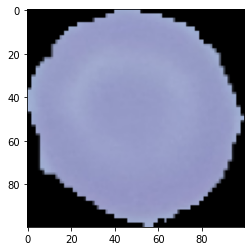

In [0]:
plt.imshow(X_zero[2020])

In [0]:
X = np.concatenate((X_one, X_zero), axis = 0)
y = np.concatenate((Y_one, Y_zero), axis = 0)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, shuffle = True)

## 3.1 Baseline CNN

Start with a convolutional model without residual connections (using batch normalization is likely to be helpful and you should try it, whether you use dropout is your choice).

In [0]:
simple_datagen = ImageDataGenerator(rescale=1./255)
datagen_train = simple_datagen.flow(X_train, y_train, batch_size=32)
datagen_val = simple_datagen.flow(X_val, y_val, batch_size=32)

In [0]:
epochs = 10
batch_size = 32
num_classes= 2

In [0]:
kernel_size = (3,3)
pool_size= (2,2)
first_conv = 32
second_conv = 64
third_conv = 128
dropout_conv = 0.25
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_conv, kernel_size, activation = 'relu', input_shape = (100, 100, 3)))
model.add(Conv2D(first_conv, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_conv, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_conv, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(num_classes, activation = "sigmoid"))

In [0]:
model.compile(Adam(learning_rate=0.001), loss = "binary_crossentropy", metrics=["accuracy"]) # Default learning rate
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
batch_normalization_17 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 46, 46, 64)       

The model seems to obtain a high validation accuracy in the first epoch. However, during the following epochs the validation accuracy does not appear to improve much, moving around valus between 0.93 and 0.96.

In [0]:
model.fit_generator(datagen_train, epochs=epochs, validation_data=datagen_val)

Epoch 1/10
646/646 [==============================] - 21s 32ms/step - loss: 0.1260 - accuracy: 0.9577 - val_loss: 0.2279 - val_accuracy: 0.9540
Epoch 2/10
646/646 [==============================] - 21s 32ms/step - loss: 0.1238 - accuracy: 0.9586 - val_loss: 0.0442 - val_accuracy: 0.9374
Epoch 3/10
646/646 [==============================] - 21s 32ms/step - loss: 0.1158 - accuracy: 0.9595 - val_loss: 0.0442 - val_accuracy: 0.9593
Epoch 4/10
646/646 [==============================] - 21s 32ms/step - loss: 0.1067 - accuracy: 0.9627 - val_loss: 0.0488 - val_accuracy: 0.9445
Epoch 5/10
646/646 [==============================] - 21s 32ms/step - loss: 0.1035 - accuracy: 0.9636 - val_loss: 0.2730 - val_accuracy: 0.9267
Epoch 6/10
646/646 [==============================] - 21s 32ms/step - loss: 0.0993 - accuracy: 0.9660 - val_loss: 0.0245 - val_accuracy: 0.9575
Epoch 7/10
646/646 [==============================] - 21s 32ms/step - loss: 0.0913 - accuracy: 0.9658 - val_loss: 0.0073 - val_accuracy:

## 3.2 Baseline CNN with data augmentation

3.2 Augment the data using rotations, mirroring and possibly other transformations. How much can you improve your original model by data augmentation?


Our data augmentation strategy is mainly based in rotations, as the cells can be rotated 360 degrees without that affecting the interpretation of the image. We also allow horizontal and vertical flips for the same reason. Additionally, use a small widht and height shift and a small shear, but considering the images tend to contain very tight margins these numbers have to be small. Very importantly, we set the fill_mode to constant to avoid artificial extensions of the cells.

In [0]:
simple_datagen = ImageDataGenerator(rescale=1./255)
augmented_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range = 30,
                                       width_shift_range=0.05,
                                       height_shift_range=0.05,
                                       shear_range=0.05,
                                       zoom_range = 0.05,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode = 'constant')

datagen_train = augmented_datagen.flow(X_train, y_train, batch_size=32)
datagen_val = simple_datagen.flow(X_val, y_val, batch_size=32)

We see that the data augmentation can create some small artifacts. However, we still expect this will improve performance.

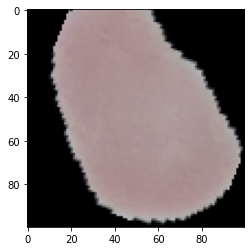

In [0]:
x_toplot, y_toplot = datagen_train.next()

plt.imshow(x_toplot[0])

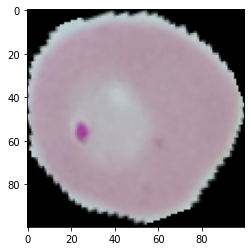

In [0]:
plt.imshow(x_toplot[2])

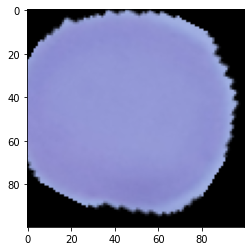

In [0]:
plt.imshow(x_toplot[3])

In [0]:
kernel_size = (3,3)
pool_size= (2,2)
first_conv = 32
second_conv = 64
third_conv = 128
dropout_conv = 0.25
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_conv, kernel_size, activation = 'relu', input_shape = (100, 100, 3)))
model.add(Conv2D(first_conv, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_conv, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_conv, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(num_classes, activation = "sigmoid"))
model.compile(Adam(learning_rate=0.001), loss = "binary_crossentropy", metrics=["accuracy"]) # Default learning rate

In this case it does not seem that including these transformations is producing a considerable difference. We tried different transformations, some mor extreme than others, obtaining similar results.

In [0]:
model.fit_generator(datagen_train, epochs=epochs, validation_data=datagen_val)

Epoch 1/10
646/646 [==============================] - 57s 88ms/step - loss: 0.1399 - accuracy: 0.9525 - val_loss: 0.0537 - val_accuracy: 0.9569
Epoch 2/10
646/646 [==============================] - 56s 86ms/step - loss: 0.1398 - accuracy: 0.9537 - val_loss: 0.1318 - val_accuracy: 0.9517
Epoch 3/10
646/646 [==============================] - 56s 86ms/step - loss: 0.1335 - accuracy: 0.9552 - val_loss: 0.0326 - val_accuracy: 0.9597
Epoch 4/10
646/646 [==============================] - 56s 86ms/step - loss: 0.1353 - accuracy: 0.9545 - val_loss: 0.1299 - val_accuracy: 0.9161
Epoch 5/10
646/646 [==============================] - 56s 86ms/step - loss: 0.1322 - accuracy: 0.9552 - val_loss: 0.6869 - val_accuracy: 0.9522
Epoch 6/10
646/646 [==============================] - 56s 87ms/step - loss: 0.1314 - accuracy: 0.9554 - val_loss: 0.0586 - val_accuracy: 0.9591
Epoch 7/10
646/646 [==============================] - 56s 86ms/step - loss: 0.1283 - accuracy: 0.9549 - val_loss: 0.0256 - val_accuracy:

## 3.3 Deeper CNN

Build a deeper model using residual connections. Show that you can build a deep model that would not be able to learn if you remove the residual connections (i.e. compare a deep model with and without residual connections while the rest of the architecture is constant).
Feel free to reuse existing architectures from the literature or use them as inspiration for your own. 


We implement an architecture similar to ResNet50 with and without residual connections. Note that we use a modified version of Marco Peixeiro's [code](https://github.com/marcopeix/Deep_Learning_AI/blob/master/4.Convolutional%20Neural%20Networks/2.Deep%20Convolutional%20Models/Residual%20Networks.ipynb).

In [0]:
def identity_block(X, f, filters, stage, block, skip = True):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    if skip:
      X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def convolutional_block(X, f, filters, stage, block, s=2, skip = True):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    if skip:
      X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1')(X_shortcut)
      X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
      X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def ResNet50(input_shape = (100, 100, 3), classes = 2, skip = False):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1, skip = skip)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b', skip = skip)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c', skip = skip)

    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2, skip = skip)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b', skip = skip)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c', skip = skip)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d', skip = skip)

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2, skip = skip)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b', skip = skip)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c', skip = skip)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d', skip = skip)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e', skip = skip)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f', skip = skip)

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2, skip = skip)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b', skip = skip)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c', skip = skip)

    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
model_withoutres = ResNet50(input_shape = (100, 100, 3), classes = 2, skip = False)
model_withoutres.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_withres = ResNet50(input_shape = (100, 100, 3), classes = 2, skip = True)
model_withres.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

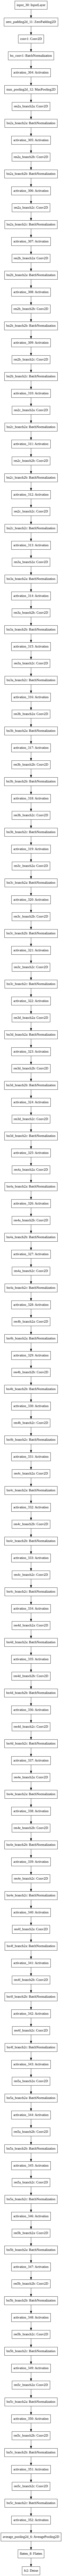

In [0]:
plot_model(model_withoutres)

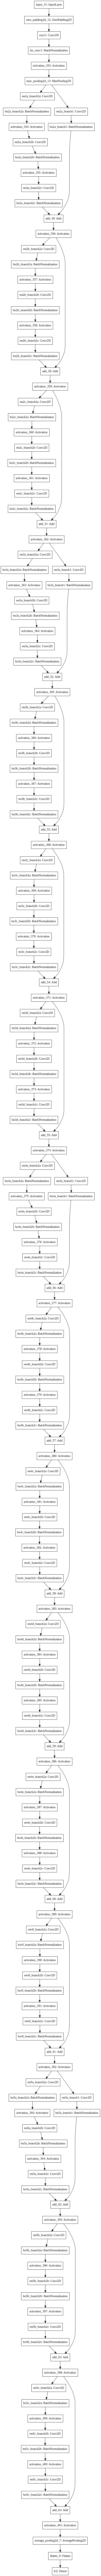

In [0]:
plot_model(model_withres)

At least in this data with this specific model, the only effect of the residuals connections is that they allowed the model to learn slightly faster. After only one epoch the model had already reached an accuracy close to 0.95 while model without residual connections required two epochs for that level of accuracy. The validation score seems very similar between the two models, something we found quite surprising. Again, this is probably a result very specific to this model and data, and we still expect that, in general, residual connections allow the use of deeper models.

In [0]:
model_withoutres.fit_generator(datagen_train, epochs=epochs, validation_data=datagen_val)

Epoch 1/10
646/646 [==============================] - 103s 159ms/step - loss: 0.6082 - accuracy: 0.6811 - val_loss: 0.6990 - val_accuracy: 0.7115
Epoch 2/10
646/646 [==============================] - 81s 126ms/step - loss: 0.2328 - accuracy: 0.9229 - val_loss: 0.0310 - val_accuracy: 0.9347
Epoch 3/10
646/646 [==============================] - 81s 125ms/step - loss: 0.1864 - accuracy: 0.9435 - val_loss: 0.0288 - val_accuracy: 0.9507
Epoch 4/10
646/646 [==============================] - 81s 126ms/step - loss: 0.1736 - accuracy: 0.9453 - val_loss: 0.0223 - val_accuracy: 0.9540
Epoch 5/10
646/646 [==============================] - 81s 126ms/step - loss: 0.1745 - accuracy: 0.9440 - val_loss: 0.9673 - val_accuracy: 0.9521
Epoch 6/10
646/646 [==============================] - 81s 125ms/step - loss: 0.1752 - accuracy: 0.9467 - val_loss: 0.2822 - val_accuracy: 0.9009
Epoch 7/10
646/646 [==============================] - 81s 126ms/step - loss: 0.1742 - accuracy: 0.9471 - val_loss: 1.4524 - val_a

In [0]:
model_withres.fit_generator(datagen_train, epochs=epochs, validation_data=datagen_val)

Epoch 1/10
646/646 [==============================] - 107s 166ms/step - loss: 0.4953 - accuracy: 0.8480 - val_loss: 0.2282 - val_accuracy: 0.9512
Epoch 2/10
646/646 [==============================] - 91s 140ms/step - loss: 0.2195 - accuracy: 0.9370 - val_loss: 0.0415 - val_accuracy: 0.9485
Epoch 3/10
646/646 [==============================] - 91s 140ms/step - loss: 0.2106 - accuracy: 0.9386 - val_loss: 0.1579 - val_accuracy: 0.9376
Epoch 4/10
646/646 [==============================] - 90s 140ms/step - loss: 0.1552 - accuracy: 0.9495 - val_loss: 0.0375 - val_accuracy: 0.9579
Epoch 5/10
646/646 [==============================] - 90s 140ms/step - loss: 0.1482 - accuracy: 0.9507 - val_loss: 0.0715 - val_accuracy: 0.9563
Epoch 6/10
646/646 [==============================] - 91s 140ms/step - loss: 0.1400 - accuracy: 0.9519 - val_loss: 0.1084 - val_accuracy: 0.9493
Epoch 7/10
646/646 [==============================] - 91s 140ms/step - loss: 0.1401 - accuracy: 0.9544 - val_loss: 0.1671 - val_a

## 3.4 Transfer learning

Reuse an existing architecture from keras (https://keras.io/applications/) and compare retraining only the densely connected layer with fine-tuning the whole network.


We are going to use the Xception model, adding a global average pooling layer (i.e. instead of a more simple flattening), a dense layer with 521 units, and the softmax. Note that a more complex approach using multiple layers could improve results. 

In [0]:
from keras.applications.xception import Xception
from keras.layers import GlobalAveragePooling2D

The result from just training the last layers of the model are relatively poor. This is not surprising: imagenet and detecting a parasite in cells are very different tasks.

In [0]:
xcep = Xception(weights='imagenet', include_top=False, input_tensor=Input((100, 100, 3)))
xception_model = Xception(weights='imagenet', include_top=False)
x = xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)
xmodel = Model(inputs=xception_model.input, outputs=predictions)

for layer in xception_model.layers:
    layer.trainable = False

xmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
xmodel.fit_generator(datagen_train, epochs=10, validation_data=datagen_val)

Epoch 1/10
646/646 [==============================] - 61s 94ms/step - loss: 0.3601 - accuracy: 0.8599 - val_loss: 0.6390 - val_accuracy: 0.6544
Epoch 2/10
646/646 [==============================] - 59s 91ms/step - loss: 0.2918 - accuracy: 0.8819 - val_loss: 0.2235 - val_accuracy: 0.7891
Epoch 3/10
646/646 [==============================] - 59s 91ms/step - loss: 0.2885 - accuracy: 0.8815 - val_loss: 0.4087 - val_accuracy: 0.7412
Epoch 4/10
646/646 [==============================] - 58s 89ms/step - loss: 0.2791 - accuracy: 0.8861 - val_loss: 0.2875 - val_accuracy: 0.6415
Epoch 5/10
646/646 [==============================] - 59s 92ms/step - loss: 0.2679 - accuracy: 0.8903 - val_loss: 0.5283 - val_accuracy: 0.7351
Epoch 6/10
646/646 [==============================] - 59s 91ms/step - loss: 0.2687 - accuracy: 0.8880 - val_loss: 0.2557 - val_accuracy: 0.8372
Epoch 7/10
646/646 [==============================] - 58s 90ms/step - loss: 0.2679 - accuracy: 0.8902 - val_loss: 1.1818 - val_accuracy:

Fine-tuning the whole network produces the best results so far, with an accuracy superior to 0.97. However, this could have probably improved more if using more epochs, a better optimizer, or potentially exploring the use of more dense layers at the end of the network.

In [0]:
xcep = Xception(weights='imagenet', include_top=False, input_tensor=Input((100, 100, 3)))
xception_model = Xception(weights='imagenet', include_top=False)
x = xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)
xmodel = Model(inputs=xception_model.input, outputs=predictions)

for layer in xception_model.layers:
        layer.trainable = True

xmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
xmodel.fit_generator(datagen_train, epochs=10, validation_data=datagen_val)

Epoch 1/10
646/646 [==============================] - 111s 171ms/step - loss: 0.1718 - accuracy: 0.9440 - val_loss: 0.1198 - val_accuracy: 0.9586
Epoch 2/10
646/646 [==============================] - 96s 149ms/step - loss: 0.1297 - accuracy: 0.9580 - val_loss: 0.0540 - val_accuracy: 0.9601
Epoch 3/10
646/646 [==============================] - 97s 149ms/step - loss: 0.1148 - accuracy: 0.9604 - val_loss: 0.0390 - val_accuracy: 0.9662
Epoch 4/10
646/646 [==============================] - 96s 149ms/step - loss: 0.1084 - accuracy: 0.9628 - val_loss: 0.2526 - val_accuracy: 0.9627
Epoch 5/10
646/646 [==============================] - 96s 149ms/step - loss: 0.1064 - accuracy: 0.9638 - val_loss: 0.0089 - val_accuracy: 0.9676
Epoch 6/10
646/646 [==============================] - 97s 149ms/step - loss: 0.1003 - accuracy: 0.9649 - val_loss: 0.2751 - val_accuracy: 0.9695
Epoch 7/10
646/646 [==============================] - 97s 150ms/step - loss: 0.1048 - accuracy: 0.9644 - val_loss: 0.0396 - val_a